<a href="https://colab.research.google.com/github/debojyotimukh/data-science-playbook/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing MNIST datasets

In [ ]:
from sklearn.datasets import fetch_openml
mnist=fetch_openml('mnist_784',version=1)
mnist.keys()

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'details', 'categories', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:
    • A DESCR key describing the dataset
    • A data key containing an array with one row per instance and one column per feature
    • A target key containing an array with the labels 

In [ ]:
x,y=mnist['data'],mnist['target']
x.shape

(70000, 784)

In [ ]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

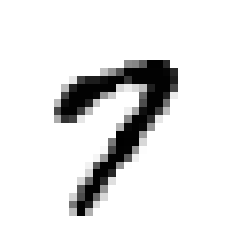

In [ ]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
some_digit = x[15]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest") 
plt.axis("off") 
plt.show()

In [ ]:
y[15]

'7'

We need to convert lebels into integers

In [ ]:
import numpy as np
y=y.astype(np.uint8)

In [ ]:
y[15]

7

# Creating Test set and Training set

 The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):


In [ ]:
X_train,y_train,X_test,y_test=x[:60000],y[:60000],x[60000:],y[60000:]

The training set is already shuffled for us, which is good as this guarantees that all cross-validation folds will be similar (you don’t want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won’t happen

# Binary Classifier

Let us write a classifier that is going to identify only one digit i.e. 5 or not-5

In [ ]:
y_test_5=(y_test==5)
y_train_5=(y_train==5)

## Stochastic Gradient Descent(SGD) classifier

 This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for online learning)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([False])

The SGDClassifier relies on randomness during training (hence the name “stochastic”). If you want reproducible results, you should set the random_state parameter.


# Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor. 

## Cross-Validation

Occasionally you will need more control over the cross-validation process than what
Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation yourself; it is actually fairly straightforward.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds=StratifiedKFold(n_splits=3,random_state=42)
for train_index,test_index in skfolds.split(X_train,y_train_5):
        clone_clf=clone(sgd_clf)
        X_train_folds=X_train[train_index]
        y_train_folds=y_train_5[train_index]
        X_test_fold=X_train[test_index]
        y_test_fold=y_train_5[test_index]
        
        clone_clf.fit(X_train_folds,y_train_folds)
        y_pred=clone_clf.predict(X_test_fold)
        n_correct=sum(y_pred==y_test_fold)
        print(n_correct/len(y_pred)) 

0.95035
0.96035
0.9604


The StratifiedKFold class performs stratified sampling (as explained in Chapter 2)
to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makes
predictions on the test fold. Then it counts the number of correct predictions and
outputs the ratio of correct predictions.

In [ ]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Lets try another dumb classifier

In [ ]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
        def fit(self,X,y=None):
                pass
        def predict(self,X):
                return np.zeros((len(X),1),dtype=bool)

In [ ]:
never_5_clf=Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the
images are 5s, so if you always guess that an image is not a 5, you will be right about
90% of the time.

#### This demonstrates why accuracy is generally not the preferred performance measure
for classifiers, especially when you are dealing with skewed datasets (i.e., when some
classes are much more frequent than others)

## Confusion Matrix

The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix

Just like the cross_val_score() function, cross_val_predict() performs K-fold
cross-validation, but instead of returning the evaluation scores, it returns the predic‐
tions made on each test fold. This means that you get a clean prediction for each
instance in the training set (“clean” meaning that the prediction is made by a model
that never saw the data during training).

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred=cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an actual class, while each column represents a predicted class

true-negatives: 53,892 are classified correctly as non-5s

false-positives: 687 were wrongly classified as 5s

false-negetives: 1891 were wrongly classified as non-5s

 true-positives: 3530 were correctly classified as 5s

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right

### Precision of classifier

$precision=\frac{TP}{TP+FP}$

TP is the number of true positives, and FP is the number of false positives.

### Recall of classifier

also called sensivity of true positive rate(TPR): this is the ratio of positive instances that are correctly detected by classifier

$recall=\frac{TP}{TP+FN}$

![](confusion_matrix_diagram.jpg)

In [ ]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [ ]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

When classifier claims an image represents a 5, it is correct only 83.7% of the time. Moreover, it only detects 65.1% of the 5s from the training set.

#### F1 score

It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1
 score is the harmonic mean of precision and recall. As the harmonic mean gives more weight to lower values i.e. clasifier will only get high F1 score if both precision and recall are high

$$F_1=\frac{2}{1/precision+1/recall}=2\times \frac{precision \times recall}{precision+recall}$$

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

The f1 score favours classifiers that have similar precision and recall. That is not always what we want: in some context we care about precision and in some other context we really care about recall.

Increasing precision reduces recall and vice versa. This is called precision/recall tradeoff.